# **Assignment 3 - RNN - Weather Time Series Forcasting**

# **Name: Dinesh Yechuri**


**A temperature forecasting sample utilizing data uploaded from AWS and Keras**

In [ ]:
!pip install tensorflow==2.12

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-04-04 20:36:56--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.169.160, 52.216.57.200, 52.217.228.176, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.169.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  43.8MB/s    in 0.3s    

2024-04-04 20:36:56 (43.8 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Examining Jena weather dataset data: 420451 rows and 15 features**

In [ ]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

num_variables = len(header)
print("Number of variables:", num_variables)
num_rows = len(lines)
print("Number of rows:", num_rows)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
Number of variables: 15
Number of rows: 420451


**Parsing the data: saving particular values in the raw_data and temperature arrays for additional processing or analysis after turning the comma-separated values into floating-point numbers.**

In [ ]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

Text(0, 0.5, 'Temperature')

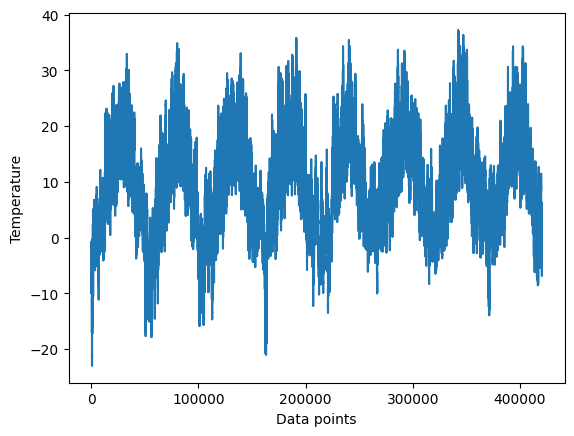

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.xlabel('Data points')
plt.ylabel('Temperature')

**Charting the first ten days of the temperature time series: Since there are 144 data points in a day, there will be 1440 data points in ten days**


Text(0, 0.5, 'Temperature')

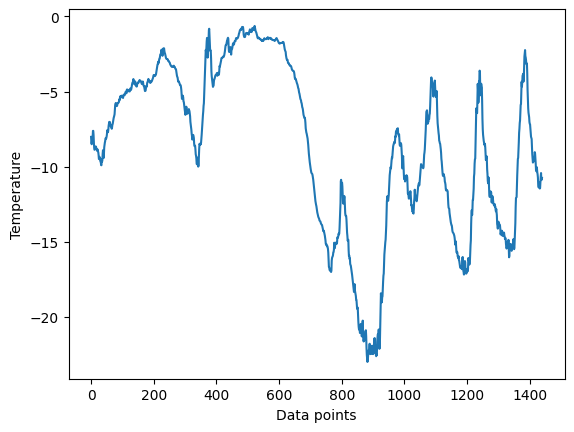

In [ ]:
plt.plot(range(1440), temperature[:1440])
plt.xlabel('Data points')
plt.ylabel('Temperature')

**Calculating how many samples each data split will require: 50% for train and 25% for validation**

In [ ]:
numb_train_samples = int(0.5 * len(raw_data))
numb_val_samples = int(0.25 * len(raw_data))
numb_test_samples = len(raw_data) - numb_train_samples - numb_val_samples
print("numb_train_samples:", numb_train_samples)
print("numb_val_samples:", numb_val_samples)
print("numb_test_samples:", numb_test_samples)

numb_train_samples: 210225
numb_val_samples: 105112
numb_test_samples: 105114


### **Preparing the data**

**Normalizing the data: Vectorization is not required because the data is already in a numerical format. Nonetheless, it is advised to normalize all variables because the data scales vary amongst them, with temperature ranging from -20 to +30 and pressure measured in millibars.**

In [ ]:
mean = raw_data[:numb_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:numb_train_samples].std(axis=0)
raw_data /= std

In [ ]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Generating training, validation, and testing datasets—this is necessary due to the large degree of redundancy in the dataset's samples. Thus, explicitly allocating memory for every sample would be inefficient. Rather, the samples will be produced dynamically.**

In [ ]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=numb_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=numb_train_samples,
    end_index=numb_train_samples + numb_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=numb_train_samples + numb_val_samples)

**Inspecting the output of one of our datasets**

In [ ]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### **A common-sense, non-machine-learning baseline**

**Calculating the sensible baseline MAE: The "evaluate_naive_method" defined function offers a starting point for assessing the effectiveness of a straightforward forecasting technique that uses the final value in the input sequence to anticipate the value that will come after it.**

In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


**A sensible baseline method would be to forecast that the temperature in the next 24 hours will be the same as it is now. The validation MAE (Mean Absolute Error) using the basic baseline is 2.44 degrees Celsius, while the test MAE is 2.62 degrees Celsius. Put another way, an average divergence of roughly 2.5 degrees would arise from presuming that the future temperature stays constant with the current temperature.**

### **A basic machine-learning model - Dense Layer**

**Training and evaluating a densely connected model**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
din = layers.Flatten()(inputs)
din = layers.Dense(16, activation="relu")(din)
outputs = layers.Dense(1)(din)
model = keras.Model(inputs, outputs)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)]

In [ ]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data = val_dataset, callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 9s 10ms/step - loss: 13.0130 - mae: 2.7909 - val_loss: 11.2674 - val_mae: 2.6725
Epoch 2/10
819/819 [==============================] - 8s 10ms/step - loss: 9.3507 - mae: 2.4099 - val_loss: 9.8002 - val_mae: 2.4829
Epoch 3/10
819/819 [==============================] - 8s 10ms/step - loss: 8.5585 - mae: 2.3074 - val_loss: 9.8417 - val_mae: 2.4814
Epoch 4/10
819/819 [==============================] - 8s 10ms/step - loss: 8.1064 - mae: 2.2463 - val_loss: 11.6001 - val_mae: 2.7206
Epoch 5/10
819/819 [==============================] - 8s 10ms/step - loss: 7.7181 - mae: 2.1927 - val_loss: 12.8736 - val_mae: 2.8388
Epoch 6/10
819/819 [==============================] - 8s 10ms/step - loss: 7.4947 - mae: 2.1621 - val_loss: 10.9776 - val_mae: 2.6346
Epoch 7/10
819/819 [==============================] - 8s 10ms/step - loss: 7.2731 - mae: 2.1310 - val_loss: 11.1115 - val_mae: 2.6569
Epoch 8/10
819/819 [==============================] - 8s 10ms/s

In [ ]:
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 3s 7ms/step - loss: 10.9328 - mae: 2.5978
Test MAE: 2.60


**Plotting results**

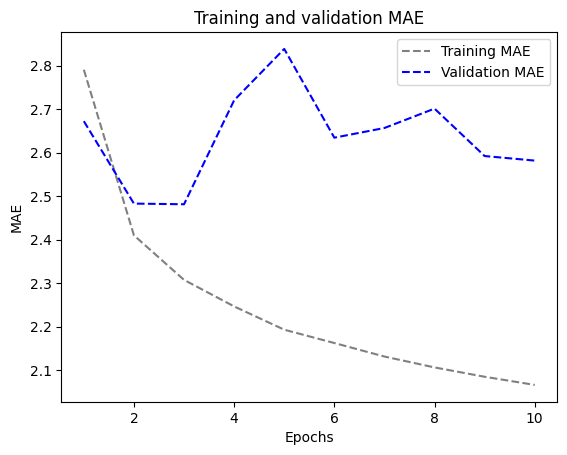

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **Let's try a 1D convolutional model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
din = layers.Conv1D(8, 24, activation="relu")(inputs)
din = layers.MaxPooling1D(2)(din)
din = layers.Conv1D(8, 12, activation="relu")(din)
din = layers.MaxPooling1D(2)(din)
din = layers.Conv1D(8, 6, activation="relu")(din)
din = layers.GlobalAveragePooling1D()(din)
outputs = layers.Dense(1)(din)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 13s 15ms/step - loss: 25.5974 - mae: 3.8903 - val_loss: 20.1408 - val_mae: 3.5686
Epoch 2/10
819/819 [==============================] - 13s 15ms/step - loss: 15.9920 - mae: 3.1758 - val_loss: 15.1018 - val_mae: 3.0433
Epoch 3/10
819/819 [==============================] - 12s 15ms/step - loss: 14.5163 - mae: 3.0261 - val_loss: 14.4453 - val_mae: 2.9773
Epoch 4/10
819/819 [==============================] - 13s 15ms/step - loss: 13.3368 - mae: 2.8922 - val_loss: 15.0482 - val_mae: 3.0447
Epoch 5/10
819/819 [==============================] - 13s 15ms/step - loss: 12.6094 - mae: 2.8076 - val_loss: 14.7939 - val_mae: 3.0307
Epoch 6/10
819/819 [==============================] - 13s 15ms/step - loss: 12.1340 - mae: 2.7515 - val_loss: 13.8923 - val_mae: 2.9298
Epoch 7/10
819/819 [==============================] - 12s 15ms/step - loss: 11.6652 - mae: 2.6970 - val_loss: 13.8451 - val_mae: 2.9156
Epoch 8/10
819/819 [============================

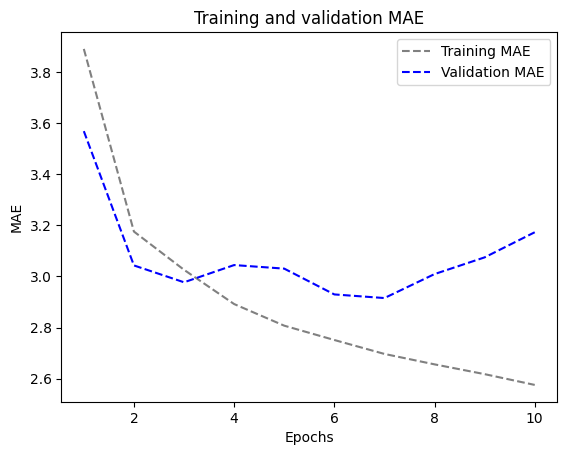

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

*It seems that the convolutional data performed poor compared to common sense or dense model. This could be because*

*- The assumption of translation invariance does not hold well for weather data.*

*- The order of the data is crucial. Recent past data is significantly more informative for predicting the temperature of the following day compared to data from several days ago. Unfortunately, a 1D convolutional neural network is unable to effectively capture this critical temporal order.*






## **A Simple RNN**

### **1.An RNN layer that can process sequences of any length**

In [ ]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimRNN.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SimRNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 20s 23ms/step - loss: 138.3046 - mae: 9.6743 - val_loss: 143.9214 - val_mae: 9.8916
Epoch 2/10
819/819 [==============================] - 18s 22ms/step - loss: 136.3698 - mae: 9.5587 - val_loss: 143.6935 - val_mae: 9.8654
Epoch 3/10
819/819 [==============================] - 18s 22ms/step - loss: 136.2469 - mae: 9.5472 - val_loss: 143.6237 - val_mae: 9.8591
Epoch 4/10
819/819 [==============================] - 18s 22ms/step - loss: 136.1637 - mae: 9.5377 - val_loss: 143.5792 - val_mae: 9.8551
Epoch 5/10
819/819 [==============================] - 18s 22ms/step - loss: 136.1308 - mae: 9.5349 - val_loss: 143.5490 - val_mae: 9.8524
Epoch 6/10
819/819 [==============================] - 18s 22ms/step - loss: 136.1190 - mae: 9.5334 - val_loss: 143.5268 - val_mae: 9.8495
Epoch 7/10
819/819 [==============================] - 18s 22ms/step - loss: 136.1046 - mae: 9.5323 - val_loss: 143.5061 - val_mae: 9.8469
Epoch 8/10
819/819 [==============

### **2.Simple RNN - Stacking RNN layers**

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
din = layers.SimpleRNN(16, return_sequences=True)(inputs)
din = layers.SimpleRNN(16, return_sequences=True)(din)
outputs = layers.SimpleRNN(16)(din)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SRNN2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SRNN2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 [==============================] - 57s 66ms/step - loss: 136.7982 - mae: 9.5638 - val_loss: 143.4283 - val_mae: 9.8362
Epoch 2/10
819/819 [==============================] - 54s 66ms/step - loss: 135.9517 - mae: 9.5123 - val_loss: 143.4560 - val_mae: 9.8412
Epoch 3/10
819/819 [==============================] - 54s 66ms/step - loss: 135.9070 - mae: 9.5065 - val_loss: 143.4506 - val_mae: 9.8409
Epoch 4/10
819/819 [==============================] - 54s 66ms/step - loss: 135.8757 - mae: 9.5022 - val_loss: 143.4268 - val_mae: 9.8362
Epoch 5/10
819/819 [==============================] - 54s 65ms/step - loss: 135.8804 - mae: 9.5024 - val_loss: 143.3875 - val_mae: 9.8305
Epoch 6/10
819/819 [==============================] - 53s 65ms/step - loss: 135.8593 - mae: 9.4998 - val_loss: 143.3862 - val_mae: 9.8320
Epoch 7/10
819/819 [==============================] - 54s 65ms/step - loss: 135.8318 - mae: 9.4954 - val_loss: 143.4472 - val_mae: 9.8407
Epoch 8/10
819/819 [==============

## **A Simple GRU (Gated Recurrent Unit)**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
din = layers.GRU(16)(inputs)
outputs = layers.Dense(1)(din)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_gru.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 48s 56ms/step - loss: 44.1053 - mae: 4.8189 - val_loss: 13.4835 - val_mae: 2.7427
Epoch 2/10
819/819 [==============================] - 44s 53ms/step - loss: 10.6885 - mae: 2.5463 - val_loss: 9.9603 - val_mae: 2.4172
Epoch 3/10
819/819 [==============================] - 43s 53ms/step - loss: 9.4667 - mae: 2.4076 - val_loss: 9.9906 - val_mae: 2.4123
Epoch 4/10
819/819 [==============================] - 43s 53ms/step - loss: 9.1369 - mae: 2.3607 - val_loss: 9.6113 - val_mae: 2.3855
Epoch 5/10
819/819 [==============================] - 43s 53ms/step - loss: 8.9224 - mae: 2.3308 - val_loss: 9.7930 - val_mae: 2.3907
Epoch 6/10
819/819 [==============================] - 43s 53ms/step - loss: 8.7435 - mae: 2.3066 - val_loss: 9.6395 - val_mae: 2.3760
Epoch 7/10
819/819 [==============================] - 44s 53ms/step - loss: 8.6059 - mae: 2.2886 - val_loss: 9.4426 - val_mae: 2.3623
Epoch 8/10
819/819 [==============================] - 43s 5

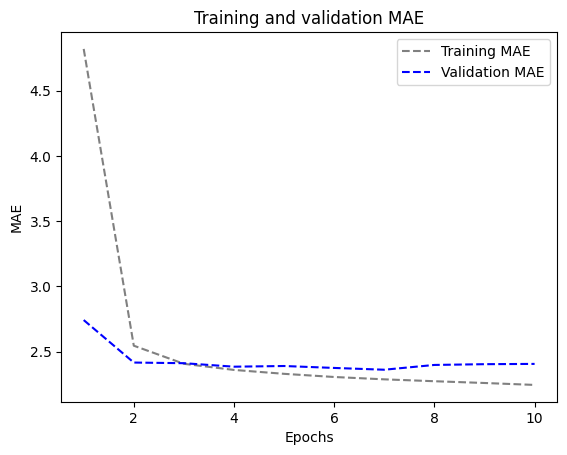

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

## **LSTM(Long Short-Term Memory )**

### **1.LSTM-Simple**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
din = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(din)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 48s 56ms/step - loss: 40.0320 - mae: 4.5834 - val_loss: 13.8590 - val_mae: 2.7392
Epoch 2/10
819/819 [==============================] - 46s 56ms/step - loss: 10.9528 - mae: 2.5761 - val_loss: 9.7142 - val_mae: 2.4303
Epoch 3/10
819/819 [==============================] - 46s 56ms/step - loss: 10.0329 - mae: 2.4717 - val_loss: 9.5010 - val_mae: 2.3994
Epoch 4/10
819/819 [==============================] - 46s 56ms/step - loss: 9.6456 - mae: 2.4185 - val_loss: 9.6409 - val_mae: 2.4260
Epoch 5/10
819/819 [==============================] - 46s 56ms/step - loss: 9.3000 - mae: 2.3764 - val_loss: 9.4904 - val_mae: 2.4046
Epoch 6/10
819/819 [==============================] - 45s 55ms/step - loss: 9.0161 - mae: 2.3378 - val_loss: 9.4514 - val_mae: 2.3941
Epoch 7/10
819/819 [==============================] - 46s 56ms/step - loss: 8.7738 - mae: 2.3055 - val_loss: 9.5102 - val_mae: 2.3987
Epoch 8/10
819/819 [==============================] - 46s 

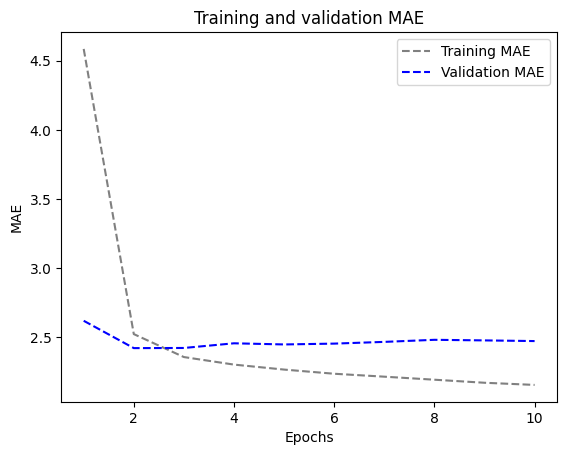

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **2.LSTM - dropout Regularization**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
din = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
din = layers.Dropout(0.5)(din)
outputs = layers.Dense(1)(din)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 65s 76ms/step - loss: 47.4186 - mae: 5.1232 - val_loss: 13.2283 - val_mae: 2.7576
Epoch 2/10
819/819 [==============================] - 63s 76ms/step - loss: 19.7332 - mae: 3.4178 - val_loss: 9.8220 - val_mae: 2.4405
Epoch 3/10
819/819 [==============================] - 63s 77ms/step - loss: 18.0418 - mae: 3.2699 - val_loss: 9.7304 - val_mae: 2.4416
Epoch 4/10
819/819 [==============================] - 62s 75ms/step - loss: 17.2264 - mae: 3.1941 - val_loss: 9.4306 - val_mae: 2.4014
Epoch 5/10
819/819 [==============================] - 62s 75ms/step - loss: 16.6897 - mae: 3.1441 - val_loss: 9.5189 - val_mae: 2.4109
Epoch 6/10
819/819 [==============================] - 62s 75ms/step - loss: 16.2472 - mae: 3.1060 - val_loss: 9.5465 - val_mae: 2.4269
Epoch 7/10
819/819 [==============================] - 62s 76ms/step - loss: 15.8702 - mae: 3.0727 - val_loss: 9.1964 - val_mae: 2.3674
Epoch 8/10
819/819 [==============================] - 

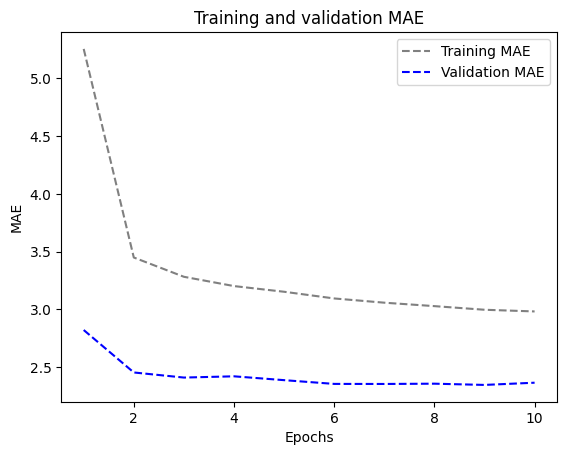

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **3.LSTM - Stacked setup with 16 units**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
din = layers.LSTM(16, return_sequences=True)(inputs)
din = layers.LSTM(16)(din)
outputs = layers.Dense(1)(din)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked1.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked1.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 94s 110ms/step - loss: 37.8716 - mae: 4.4548 - val_loss: 12.0147 - val_mae: 2.6167
Epoch 2/10
819/819 [==============================] - 91s 111ms/step - loss: 10.1397 - mae: 2.4739 - val_loss: 9.2846 - val_mae: 2.3785
Epoch 3/10
819/819 [==============================] - 90s 110ms/step - loss: 8.7363 - mae: 2.2995 - val_loss: 9.7300 - val_mae: 2.4422
Epoch 4/10
819/819 [==============================] - 90s 110ms/step - loss: 8.1416 - mae: 2.2195 - val_loss: 9.9249 - val_mae: 2.4799
Epoch 5/10
819/819 [==============================] - 89s 109ms/step - loss: 7.6655 - mae: 2.1551 - val_loss: 10.5729 - val_mae: 2.5616
Epoch 6/10
819/819 [==============================] - 89s 109ms/step - loss: 7.2693 - mae: 2.0953 - val_loss: 10.1224 - val_mae: 2.5010
Epoch 7/10
819/819 [==============================] - 89s 108ms/step - loss: 6.9253 - mae: 2.0434 - val_loss: 10.9319 - val_mae: 2.5873
Epoch 8/10
819/819 [=============================

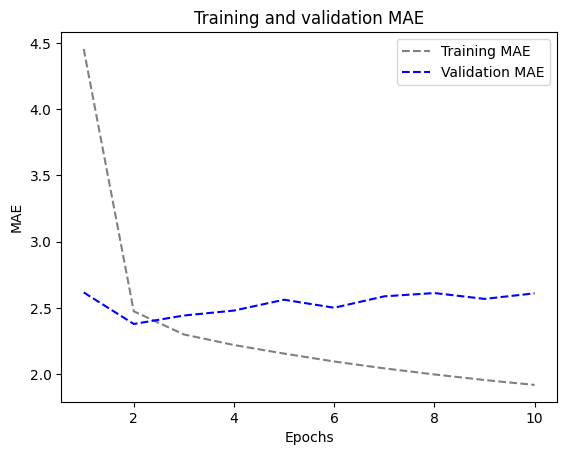

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **4.LSTM - Stacked setup with 32 units**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
din = layers.LSTM(32, return_sequences=True)(inputs)
din = layers.LSTM(32)(din)
outputs = layers.Dense(1)(din)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 137s 164ms/step - loss: 22.5627 - mae: 3.3756 - val_loss: 9.8192 - val_mae: 2.4615
Epoch 2/10
819/819 [==============================] - 132s 161ms/step - loss: 7.8676 - mae: 2.1891 - val_loss: 10.4989 - val_mae: 2.5583
Epoch 3/10
819/819 [==============================] - 131s 160ms/step - loss: 6.2477 - mae: 1.9480 - val_loss: 11.7871 - val_mae: 2.7159
Epoch 4/10
819/819 [==============================] - 132s 161ms/step - loss: 5.1364 - mae: 1.7586 - val_loss: 12.3099 - val_mae: 2.7471
Epoch 5/10
819/819 [==============================] - 132s 161ms/step - loss: 4.4274 - mae: 1.6289 - val_loss: 13.1282 - val_mae: 2.8374
Epoch 6/10
819/819 [==============================] - 133s 162ms/step - loss: 3.8546 - mae: 1.5150 - val_loss: 13.0977 - val_mae: 2.8468
Epoch 7/10
819/819 [==============================] - 133s 162ms/step - loss: 3.4404 - mae: 1.4254 - val_loss: 14.3524 - val_mae: 2.9668
Epoch 8/10
819/819 [=====================

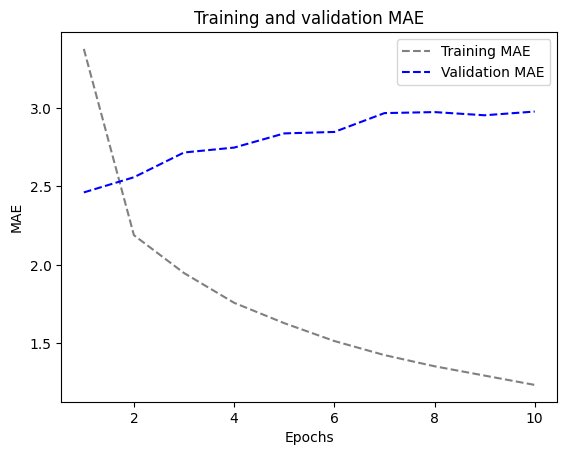

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **5.LSTM - Stacked setup with 8 units**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
din = layers.LSTM(8, return_sequences=True)(inputs)
din = layers.LSTM(8)(din)
outputs = layers.Dense(1)(din)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked3.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked3.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 76s 89ms/step - loss: 58.8321 - mae: 5.7915 - val_loss: 28.8597 - val_mae: 3.9852
Epoch 2/10
819/819 [==============================] - 72s 87ms/step - loss: 18.0468 - mae: 3.1759 - val_loss: 12.5840 - val_mae: 2.6907
Epoch 3/10
819/819 [==============================] - 73s 89ms/step - loss: 10.9192 - mae: 2.5750 - val_loss: 10.2721 - val_mae: 2.4747
Epoch 4/10
819/819 [==============================] - 73s 89ms/step - loss: 10.0382 - mae: 2.4774 - val_loss: 9.9316 - val_mae: 2.4384
Epoch 5/10
819/819 [==============================] - 72s 88ms/step - loss: 9.7695 - mae: 2.4420 - val_loss: 10.1523 - val_mae: 2.4516
Epoch 6/10
819/819 [==============================] - 72s 88ms/step - loss: 9.5514 - mae: 2.4124 - val_loss: 10.0573 - val_mae: 2.4375
Epoch 7/10
819/819 [==============================] - 74s 90ms/step - loss: 9.3915 - mae: 2.3923 - val_loss: 10.3515 - val_mae: 2.4833
Epoch 8/10
819/819 [==============================] 

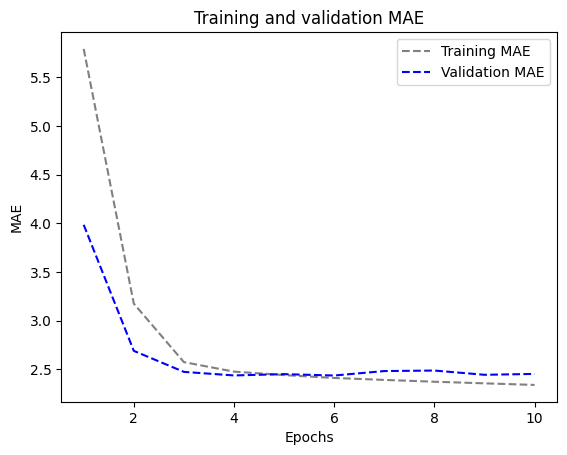

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **6.LSTM - dropout-regularized, stacked model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
din = layers.LSTM(8, recurrent_dropout=0.5, return_sequences=True)(inputs)
din = layers.LSTM(8, recurrent_dropout=0.5)(din)
din = layers.Dropout(0.5)(din)
outputs = layers.Dense(1)(din)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_LSTM_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 111s 130ms/step - loss: 74.3889 - mae: 6.6296 - val_loss: 34.6505 - val_mae: 4.3987
Epoch 2/10
819/819 [==============================] - 106s 129ms/step - loss: 32.3607 - mae: 4.2755 - val_loss: 13.8734 - val_mae: 2.7839
Epoch 3/10
819/819 [==============================] - 106s 129ms/step - loss: 24.6439 - mae: 3.7648 - val_loss: 10.7099 - val_mae: 2.4971
Epoch 4/10
819/819 [==============================] - 105s 129ms/step - loss: 22.7470 - mae: 3.6237 - val_loss: 10.1412 - val_mae: 2.4543
Epoch 5/10
819/819 [==============================] - 105s 128ms/step - loss: 21.3876 - mae: 3.5157 - val_loss: 9.7281 - val_mae: 2.4106
Epoch 6/10
819/819 [==============================] - 105s 128ms/step - loss: 20.2466 - mae: 3.4268 - val_loss: 9.5135 - val_mae: 2.3863
Epoch 7/10
819/819 [==============================] - 105s 128ms/step - loss: 19.4589 - mae: 3.3669 - val_loss: 9.2690 - val_mae: 2.3548
Epoch 8/10
819/819 [=================

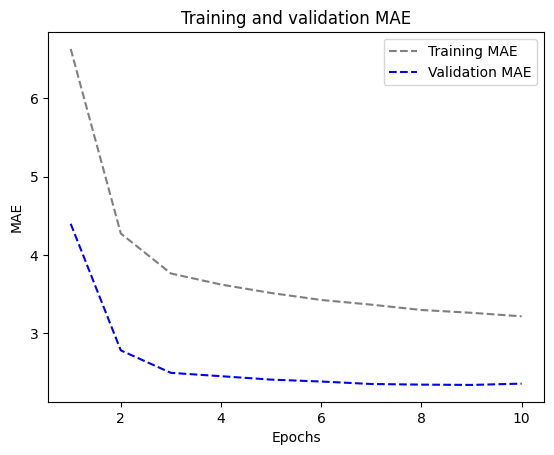

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

## **Bidirectional LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
din = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(din)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirec_LSTM.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                     callbacks=callbacks)

model = keras.models.load_model("jena_bidirec_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 [==============================] - 51s 58ms/step - loss: 25.9273 - mae: 3.6567 - val_loss: 10.4757 - val_mae: 2.5175
Epoch 2/10
819/819 [==============================] - 48s 59ms/step - loss: 9.4196 - mae: 2.3907 - val_loss: 9.4030 - val_mae: 2.3917
Epoch 3/10
819/819 [==============================] - 49s 59ms/step - loss: 8.5676 - mae: 2.2747 - val_loss: 9.4404 - val_mae: 2.3839
Epoch 4/10
819/819 [==============================] - 49s 60ms/step - loss: 8.0018 - mae: 2.1993 - val_loss: 9.8783 - val_mae: 2.4401
Epoch 5/10
819/819 [==============================] - 48s 59ms/step - loss: 7.6206 - mae: 2.1480 - val_loss: 10.4116 - val_mae: 2.5068
Epoch 6/10
819/819 [==============================] - 48s 59ms/step - loss: 7.3127 - mae: 2.1039 - val_loss: 10.5412 - val_mae: 2.5185
Epoch 7/10
819/819 [==============================] - 48s 59ms/step - loss: 7.1021 - mae: 2.0737 - val_loss: 10.3589 - val_mae: 2.5068
Epoch 8/10
819/819 [==============================] - 48s

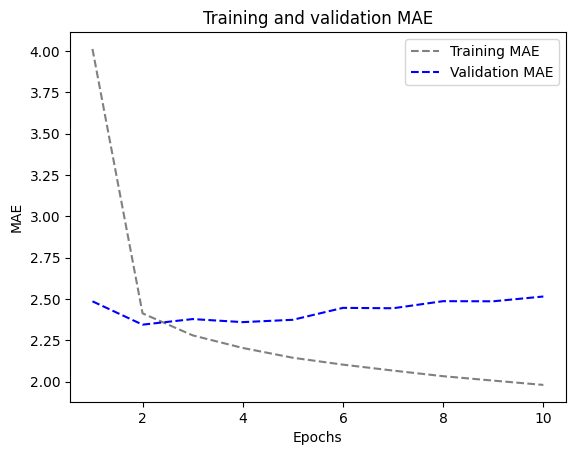

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **1D Convnets and LSTM togther**

In [ ]:

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
din = layers.Conv1D(64, 3, activation='relu')(inputs)
din = layers.MaxPooling1D(3)(din)
din = layers.Conv1D(128, 3, activation='relu')(din)
din = layers.GlobalMaxPooling1D()(din)
din = layers.Reshape((-1, 128))(din)  # Reshape the data to be 3D
din = layers.LSTM(16)(din)
outputs = layers.Dense(1)(din)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_Conv_LSTM.keras", save_best_only=True)
]

history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_Conv_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 16s 17ms/step - loss: 42.2077 - mae: 4.8441 - val_loss: 25.6140 - val_mae: 4.0093
Epoch 2/10
819/819 [==============================] - 13s 16ms/step - loss: 16.8472 - mae: 3.1724 - val_loss: 21.3697 - val_mae: 3.6543
Epoch 3/10
819/819 [==============================] - 13s 16ms/step - loss: 14.0129 - mae: 2.9000 - val_loss: 24.9389 - val_mae: 4.0038
Epoch 4/10
819/819 [==============================] - 13s 16ms/step - loss: 12.5293 - mae: 2.7403 - val_loss: 23.2003 - val_mae: 3.8476
Epoch 5/10
819/819 [==============================] - 14s 16ms/step - loss: 11.4930 - mae: 2.6194 - val_loss: 21.2519 - val_mae: 3.6790
Epoch 6/10
819/819 [==============================] - 13s 16ms/step - loss: 10.6627 - mae: 2.5168 - val_loss: 22.1726 - val_mae: 3.7358
Epoch 7/10
819/819 [==============================] - 13s 16ms/step - loss: 9.9693 - mae: 2.4299 - val_loss: 23.6268 - val_mae: 3.9153
Epoch 8/10
819/819 [=============================

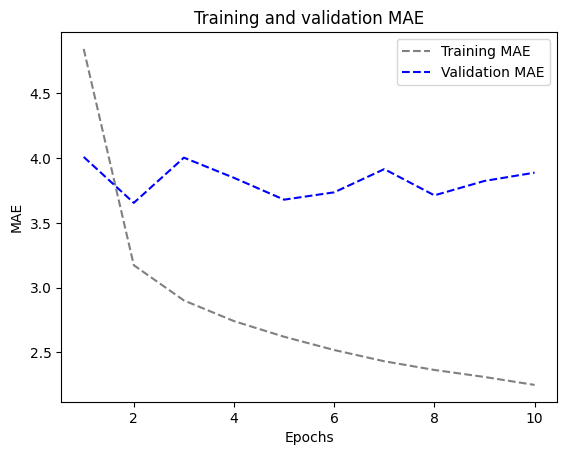

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

We built **14** models: Following are the details;

**Model 1:** common-sense, non-machine-learning baseline

**Model 2:** A basic machine-learning model

**Model 3:** 1D convolutional model

**Model 4:** Simple RNN layer that can process sequences of any length

**Model 5:** Simple RNN - Stacking RNN layers

**Model 6:** A Simple GRU (Gated Recurrent Unit)

**Model 7:** LSTM-Simple

**Model 8:** LSTM - dropout Regularization

**Model 9:** Stacked setup with 16 units

**Model 10:** Stacked setup with 32 units

**Model 11:** Stacked setup with 8 units

**Model 12:** LSTM - dropout-regularized, stacked

**Model 13:** Bidirectional LSTM

**Model 14:** 1D Convnets and LSTM togther

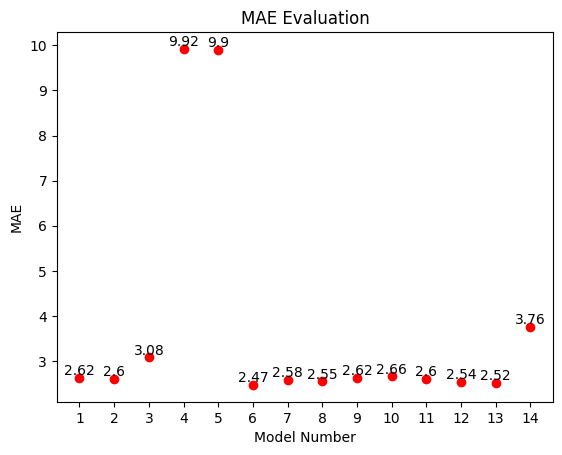

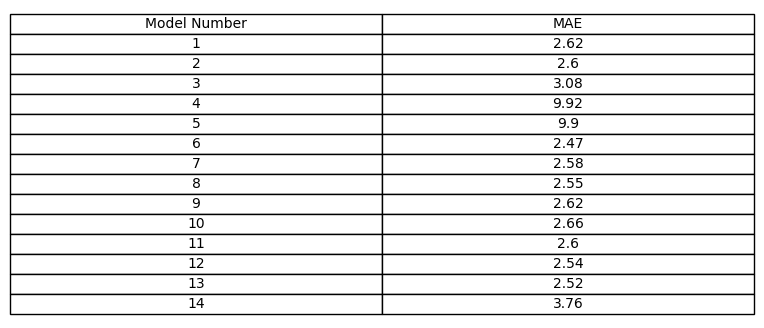

In [ ]:
Models = ("1","2","3","4","5","6","7","8","9","10","11","12","13","14")
Mae = (2.62,2.60,3.08,9.92,9.90,2.47,2.58,2.55,2.62,2.66,2.60,2.54,2.52,3.76)

# MAE Evaluation
plt.scatter(Models, Mae, color="red")
plt.title("MAE Evaluation")
plt.xlabel("Model Number")
plt.ylabel("MAE")

for (xi, yi) in zip(Models,Mae):
    plt.text(xi, yi, yi, va='bottom', ha='center')

plt.show()

# Creating a table
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('tight')
ax.axis('off')
table_data = list(zip(Models, Mae))
table = ax.table(cellText=table_data, colLabels=['Model Number', 'MAE'], cellLoc = 'center', loc='center')

# Adding style to the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

plt.show()